In [1]:
import xarray as xr
import numpy
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [2]:
def flatten_array(var):
    var_1d = var.stack(stacked=[...]).values
    var_1d = var_1d[~numpy.isnan(var_1d)]
    return var_1d

In [3]:
datapath = '/p/user_pub/e3sm/zhang40/COSP_phase_data'
temp = xr.open_dataset(f'{datapath}/data/T_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['T']
cice = xr.open_dataset(f'{datapath}/data/CLDICE_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['CLDICE']
cliq = xr.open_dataset(f'{datapath}/data/CLDLIQ_200001_201412.nc').isel(time=slice(0, 12)).sel(lat=slice(-70,-30))['CLDLIQ']

In [4]:
ctot = cice + cliq
ctot_sel = ctot.where((temp >= 220) & (temp <= 280)).where(ctot > 1e-9)
cliq_sel = cliq.where(ctot_sel.notnull())
temp_sel = temp.where(ctot_sel.notnull())

In [5]:
ctot_1d = flatten_array(ctot_sel)
cliq_1d = flatten_array(cliq_sel)
temp_1d = flatten_array(temp_sel)
lcf = cliq_1d/ctot_1d

In [6]:
# plt.scatter(temp_1d, lcf, s=1)

In [7]:
mean_stat = binned_statistic(temp_1d, lcf, 
                             statistic='mean', 
                             bins=20, 
                             range=(220, 280))

In [8]:
print(mean_stat.statistic)

[1.24389650e-04 7.59147454e-04 3.27332471e-03 1.14166147e-02
 3.14388247e-02 6.75562676e-02 1.24064037e-01 1.90791197e-01
 2.54556470e-01 3.19181640e-01 4.03884829e-01 5.03553591e-01
 6.07559780e-01 7.07604378e-01 8.00053005e-01 8.84473424e-01
 9.50170120e-01 9.83287024e-01 9.94264911e-01 9.98387301e-01]


In [9]:
print(mean_stat.bin_edges)

[220. 223. 226. 229. 232. 235. 238. 241. 244. 247. 250. 253. 256. 259.
 262. 265. 268. 271. 274. 277. 280.]


In [10]:
bin_center = (mean_stat.bin_edges[:-1] + mean_stat.bin_edges[1:]) / 2

In [11]:
import math
obs = []
for ibin, temp in enumerate(bin_center):
    print(temp,ibin)
    temp = temp - 273.15
    pt=7.6725+1.0118*temp+0.1422*(temp**2)+0.0106*(temp**3)+3.39*1e-4*(temp**4)+3.95*1e-6*(temp**5)
    lcf = 1./(1.+math.exp(-1.*pt))
    obs.append(lcf)
# print(obs)

221.5 0
224.5 1
227.5 2
230.5 3
233.5 4
236.5 5
239.5 6
242.5 7
245.5 8
248.5 9
251.5 10
254.5 11
257.5 12
260.5 13
263.5 14
266.5 15
269.5 16
272.5 17
275.5 18
278.5 19
[1.8845935193007853e-72, 1.8472161668637885e-45, 2.041889363422394e-27, 6.882302210046349e-16, 6.406487946180957e-09, 5.606765643291318e-05, 0.006581619701797825, 0.06700415229116018, 0.20490300045170462, 0.39695196057735066, 0.6324045877987717, 0.8322720065361159, 0.9348059765926484, 0.9726770645697281, 0.9857175992475639, 0.9912230827269705, 0.9955750071329806, 0.9991522346371596, 0.9999830244056622, 0.9999999947966809]


In [12]:
# TODO add CMIP results.
import scipy.io
cmip5 = scipy.io.loadmat(f'{datapath}/obs/SCL_T5050_30S_70S.mat')
for imod in range(2):#range(len(cmip5['MODEL'][:])):
    print(imod,cmip5['MODEL'][imod] )
    print(type(cmip5['T'][0]), cmip5['T'][imod][0], cmip5['SCL'][imod][0])

0 [array(['bcc-csm1-1'], dtype='<U10')]
<class 'numpy.ndarray'> [[222.04507446]
 [223.43270874]
 [224.77565002]
 [226.1990509 ]
 [227.57893372]
 [228.95613098]
 [230.35195923]
 [231.76031494]
 [233.16711426]
 [234.57528687]
 [235.97311401]
 [237.37559509]
 [238.78048706]
 [240.18544006]
 [241.59188843]
 [243.00248718]
 [244.40193176]
 [245.80462646]
 [247.20553589]
 [248.61352539]
 [250.0189209 ]
 [251.42225647]
 [252.82896423]
 [254.22351074]
 [255.62895203]
 [257.03417969]
 [258.43884277]
 [259.84579468]
 [261.24465942]
 [262.64456177]
 [264.05047607]
 [265.45150757]
 [266.84805298]
 [268.22412109]
 [269.5975647 ]
 [270.97567749]
 [272.37420654]
 [273.75357056]] [[0.01207923]
 [0.01513467]
 [0.02119955]
 [0.03143653]
 [0.04799106]
 [0.07385303]
 [0.11187079]
 [0.15458117]
 [0.19863495]
 [0.24362269]
 [0.2921851 ]
 [0.34157047]
 [0.39170852]
 [0.44099244]
 [0.49041891]
 [0.53915596]
 [0.58663601]
 [0.63365805]
 [0.67712867]
 [0.71641475]
 [0.75220531]
 [0.78483856]
 [0.81504905]
 [0.8

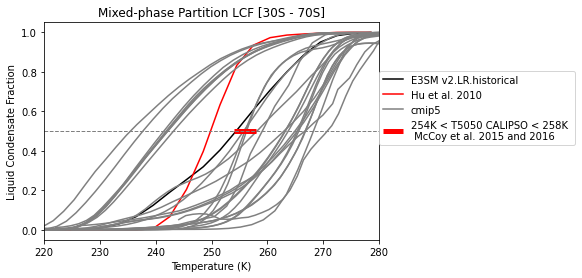

In [15]:
fig, ax = plt.subplots()

ax.plot(bin_center, mean_stat.statistic, color = 'black', label='E3SM v2.LR.historical')
ax.plot(bin_center, obs, color = 'red', label='Hu et al. 2010')
for imod in range(len(cmip5['MODEL'][:])):
    if imod == 0:
        ax.plot(cmip5['T'][imod][0], cmip5['SCL'][imod][0], color = 'grey', label='cmip5')
    else:
        ax.plot(cmip5['T'][imod][0], cmip5['SCL'][imod][0], color = 'grey')#, label=cmip5['MODEL'][imod][0][0])

ax.hlines(y=0.5, xmin=254, xmax=258, linewidth=5, color='r', label='254K < T5050 CALIPSO < 258K \n McCoy et al. 2015 and 2016')
ax.hlines(y=0.5, xmin=220, xmax=280,  linewidth=1, linestyles='--', color='grey')
ax.set_ylabel('Liquid Condensate Fraction')
ax.set_xlim(220,280)
ax.set_xlabel('Temperature (K)')
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.8))
ax.set_title('Mixed-phase Partition LCF [30S - 70S]')
plt.show()
